# Model Validation Notebook

This notebook provides a comprehensive validation for all implemented time series generative models (parametric and non-parametric). It covers the entire pipeline from data preprocessing to model training and synthetic data generation, ensuring that each model functions as expected and produces output in the desired format `(R, l, N)`.

## Table of Contents:
1.  [Setup and Imports](#Setup-and-Imports)
2.  [Data Preprocessing](#Data-Preprocessing)
3.  [Parametric Model Validation](#Parametric-Model-Validation)
    *   [Geometric Brownian Motion](#Geometric-Brownian-Motion)
    *   [Ornstein-Uhlenbeck Process](#Ornstein-Uhlenbeck-Process)
4.  [Non-Parametric Model Validation](#Non-Parametric-Model-Validation)
    *   [Vanilla GAN](#Vanilla-GAN)
    *   [Wasserstein GAN](#Wasserstein-GAN)



In [ ]:
import sys
import numpy as np
import torch
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
project_root = Path().resolve().parents[0]
sys.path.append(str(project_root))

print(f"Project root added to sys.path: {project_root}")

from src.utils.preprocessing_utils import (
    TimeSeriesDataset,
    create_dataloaders,
    preprocess_data
)

from src.models.base.base_model import ParametricModel, DeepLearningModel
from src.models.parametric.gbm import GeometricBrownianMotion
from src.models.parametric.ou_process import OrnsteinUhlenbeckProcess
from src.models.parametric.merton_jump_diffusion import MertonJumpDiffusion
from src.models.parametric.garch11 import GARCH11
from src.models.parametric.de_jump_diffusion import DoubleExponentialJumpDiffusion
from src.models.parametric.block_bootstrap import BlockBootstrap

from src.models.non_parametric.time_gan import TimeGAN

print("All necessary modules imported successfully!")

Project root added to sys.path: C:\Users\14165\Downloads\Unified-benchmark-for-SDGFTS-main
All necessary modules imported successfully!


## Data Preprocessing

This section demonstrates how to preprocess a sample dataset (`GOOG.csv`) using the provided utilities and create PyTorch `DataLoader` objects. This data will be used to train and validate our generative models.



In [2]:
# --- Normalized; Non-parametric case; Batched time series ---
config_non_parametric = {
    'original_data_path': str(project_root / 'data' / 'raw' / 'GOOG' / 'GOOG.csv'),
    'valid_ratio': 0.1,
    'do_normalization': True,
    'seed': 42
}

print(f"Preprocessing normalized data with config: {config_non_parametric}")

train_data_norm_np, valid_data_norm_np = preprocess_data(config_non_parametric)

batch_size = 32
train_loader_norm, valid_loader_norm = create_dataloaders(
    train_data_norm_np, valid_data_norm_np,
    batch_size=batch_size,
    train_seed=42,
    valid_seed=123,
    num_workers=0,
    pin_memory=False
)

print(f"\n[Normalized] Train data shape: {train_data_norm_np.shape}")
print(f"[Normalized] Valid data shape: {valid_data_norm_np.shape}")
print(f"[Normalized] Number of training batches: {len(train_loader_norm)}")
print(f"[Normalized] Number of validation batches: {len(valid_loader_norm)}")

num_samples_real, length, num_channels = train_data_norm_np.shape
print(f"\n[Normalized] Inferred model output dimensions: length={length}, num_channels={num_channels}")



Preprocessing normalized data with config: {'original_data_path': 'C:\\Users\\14165\\Downloads\\Unified-benchmark-for-SDGFTS-main\\data\\raw\\GOOG\\GOOG.csv', 'valid_ratio': 0.1, 'do_normalization': True, 'seed': 42}
Data preprocessing with settings:{'original_data_path': 'C:\\Users\\14165\\Downloads\\Unified-benchmark-for-SDGFTS-main\\data\\raw\\GOOG\\GOOG.csv', 'valid_ratio': 0.1, 'do_normalization': True, 'seed': 42}
Data shape: (1131, 125, 5)
Preprocessing done.


[Normalized] Train data shape: (1017, 125, 5)
[Normalized] Valid data shape: (114, 125, 5)
[Normalized] Number of training batches: 32
[Normalized] Number of validation batches: 4

[Normalized] Inferred model output dimensions: length=125, num_channels=5


In [3]:
# --- Unnormalized; Parametric Case; Use full time series ---
config_parametric = {
    'original_data_path': str(project_root / 'data' / 'raw' / 'GOOG' / 'GOOG.csv'),
    'valid_ratio': 0.1,
    'is_parametric': True
}

print(f"Preprocessing full dataset with configs: {config_non_parametric}")

train_data_para, valid_data_para = preprocess_data(config_parametric)

print(f"\n[Unnormalized] Type of train_data_para: {type(train_data_para)}")
print(f"[Unnormalized] Type of valid_data_para: {type(valid_data_para)}")
print(f"[Unnormalized] Train data shape: {train_data_para.shape}")
print(f"[Unnormalized] Valid data shape: {valid_data_para.shape}")

length, num_channels = train_data_para.shape
print(f"\n[Unnormalized] Inferred model output dimensions: length={length}, num_channels={num_channels}")

Preprocessing full dataset with configs: {'original_data_path': 'C:\\Users\\14165\\Downloads\\Unified-benchmark-for-SDGFTS-main\\data\\raw\\GOOG\\GOOG.csv', 'valid_ratio': 0.1, 'do_normalization': True, 'seed': 42}
Data preprocessing with settings:{'original_data_path': 'C:\\Users\\14165\\Downloads\\Unified-benchmark-for-SDGFTS-main\\data\\raw\\GOOG\\GOOG.csv', 'valid_ratio': 0.1, 'is_parametric': True}
Data shape: (1255, 5)

[Unnormalized] Type of train_data_para: <class 'torch.Tensor'>
[Unnormalized] Type of valid_data_para: <class 'torch.Tensor'>
[Unnormalized] Train data shape: torch.Size([1129, 5])
[Unnormalized] Valid data shape: torch.Size([126, 5])

[Unnormalized] Inferred model output dimensions: length=1129, num_channels=5


## Stochastic Model Validation

This section validates the functionality of each stochastic time series generative model. For each model, we will:
1.  Instantiate the model with appropriate parameters.
2.  Train the model using the preprocessed training data.
3.  Generate new synthetic time series samples.
4.  Verify the shape and basic statistics of the generated data.



In [4]:
def plot_outputs(train_data_para, generated_data, num_generated_samples, length):
    """
    Assumes train_data_para and generated_data have 6 channels:
      Channel 0: timestep (not forecasted)
      Channels 1: Open
      Channel 2: Close
      Channel 3: High
      Channel 4: Low
    Plots each forecasted channel's statistics and overlay vs generated samples.

    Note:
        - Blue line: the real training data.
        - Gray lines: each generated/simulated sample.
    """
    channel_names = ["Time", "Open", "Close", "High", "Low"]
    for c in range(1, len(channel_names)):
        chan_data = generated_data[..., c]
        min_val = chan_data.min().item()
        max_val = chan_data.max().item()
        mean_val = chan_data.mean().item()
        print(f"{channel_names[c]} (channel {c}): min={min_val:.4f}, max={max_val:.4f}, mean={mean_val:.4f}")
        
        plt.figure(figsize=(12, 5))
        y_real = train_data_para[:, c].cpu().numpy() if hasattr(train_data_para, "cpu") else train_data_para[:, c]
        plt.plot(range(length), y_real, label="Original Train", color='blue', linewidth=2)

        for i in range(num_generated_samples):
            y_fake = generated_data[i, :, c].cpu().numpy() if hasattr(generated_data, "cpu") else generated_data[i, :, c]
            plt.plot(
                range(length), y_fake,
                alpha=0.7, linestyle="--", color='gray',
                label="Generated" if i == 0 else None)
        plt.title(f"{channel_names[c]}: Original vs Generated Samples")
        plt.xlabel("Time Step")
        plt.ylabel(channel_names[c])
        plt.legend()
        plt.tight_layout()
        plt.show()

### Geometric Brownian Motion




Validating Geometric Brownian Motion (GBM)
GBM Model instantiated: <src.models.parametric.gbm.GeometricBrownianMotion object at 0x000001F9FB98BEF0>
Fitting GBM model...
GBM Parameters: {'mu': tensor([6.7114e-09, 6.4816e-09, 6.5839e-09, 6.9651e-09]), 'sigma': tensor([6.2000e-05, 5.5524e-05, 5.7757e-05, 6.2572e-05])}


Generated GBM data shape: torch.Size([20, 1129, 5])
GBM: Generated data shape is correct.
Open (channel 1): min=29.1914, max=709.1445, mean=141.7783


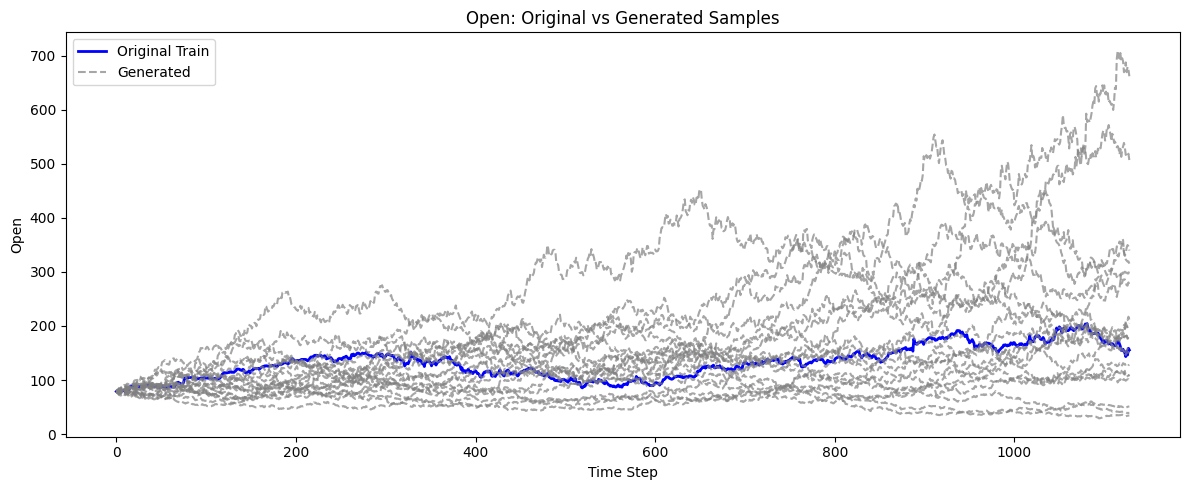

Close (channel 2): min=16.5619, max=452.5950, mean=107.1812


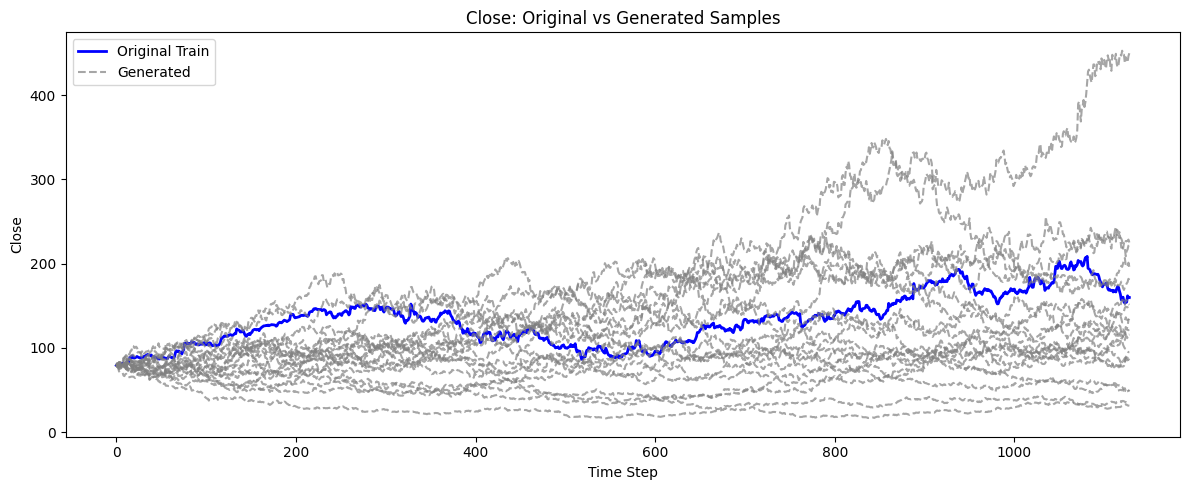

High (channel 3): min=24.6782, max=934.4095, mean=125.8325


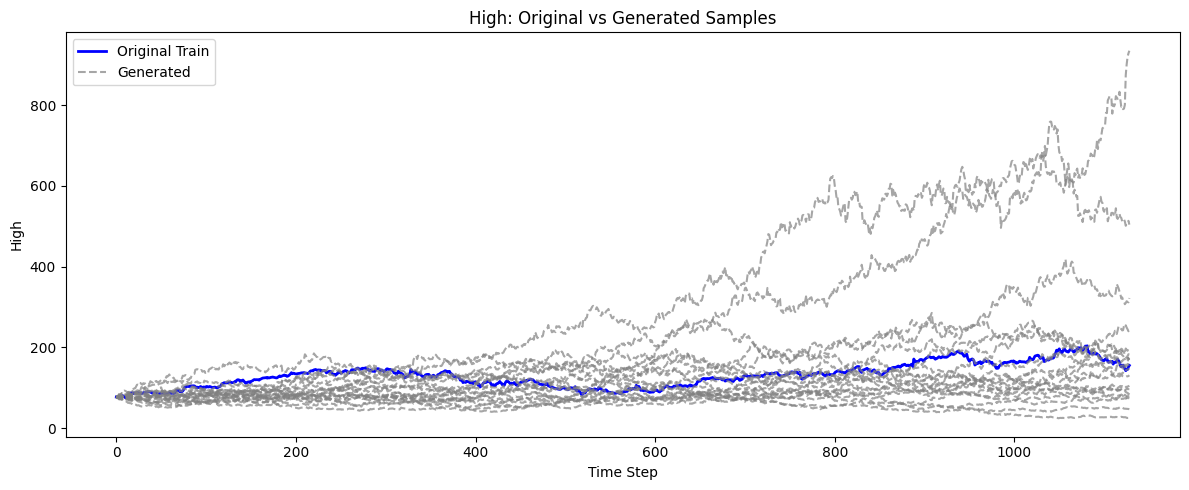

Low (channel 4): min=32.1238, max=420.0327, mean=112.3767


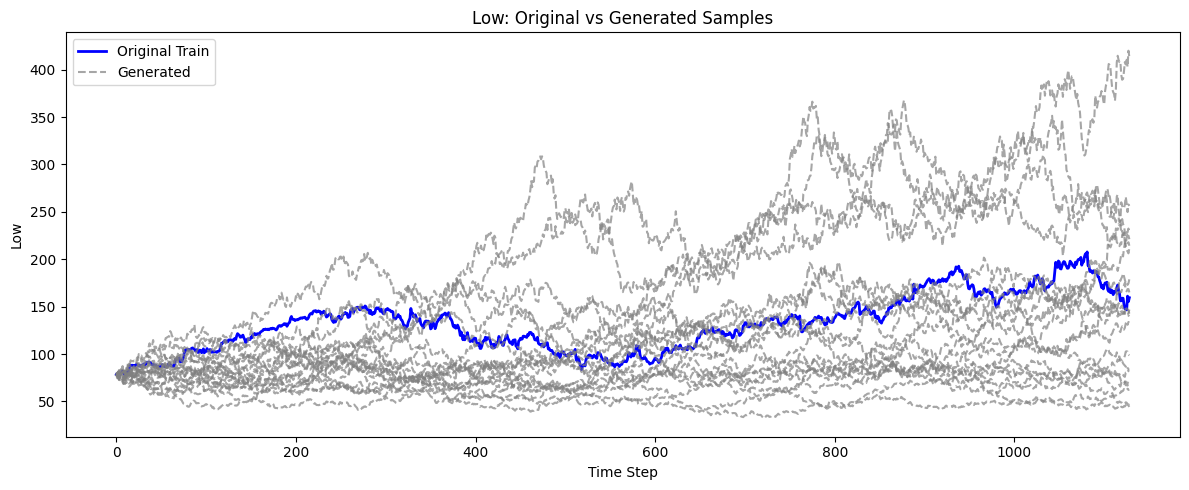

In [5]:
print("\n" + "=" * 50)
print("Validating Geometric Brownian Motion (GBM)")
print("=" * 50)


length, num_channels = train_data_para.shape
initial_price = train_data_para[0]

gbm_model = GeometricBrownianMotion(length=length, num_channels=num_channels, initial_price=initial_price)
print(f"GBM Model instantiated: {gbm_model}")

print("Fitting GBM model...")
gbm_parameters = gbm_model.fit(train_data_para)
print(f"GBM Parameters: {gbm_parameters}")

num_generated_samples = 20
gbm_generated_data = gbm_model.generate(num_generated_samples)
print(f"Generated GBM data shape: {gbm_generated_data.shape}")

assert gbm_generated_data.shape == (num_generated_samples, length, num_channels), \
    f"GBM: Generated data shape mismatch. Expected ({num_generated_samples}, {length}, {num_channels}), got {gbm_generated_data.shape}"
print("GBM: Generated data shape is correct.")

plot_outputs(train_data_para, gbm_generated_data, num_generated_samples, length)

### Ornstein-Uhlenbeck Process




Validating Ornstein-Uhlenbeck (O-U) Process
O-U Model instantiated: <src.models.parametric.ou_process.OrnsteinUhlenbeckProcess object at 0x000001F9FBD032C0>
Fitting O-U model...
Generated O-U data shape: torch.Size([10, 1129, 5])
O-U: Generated data shape is correct.
Open (channel 1): min=63.9354, max=196.2951, mean=137.5239


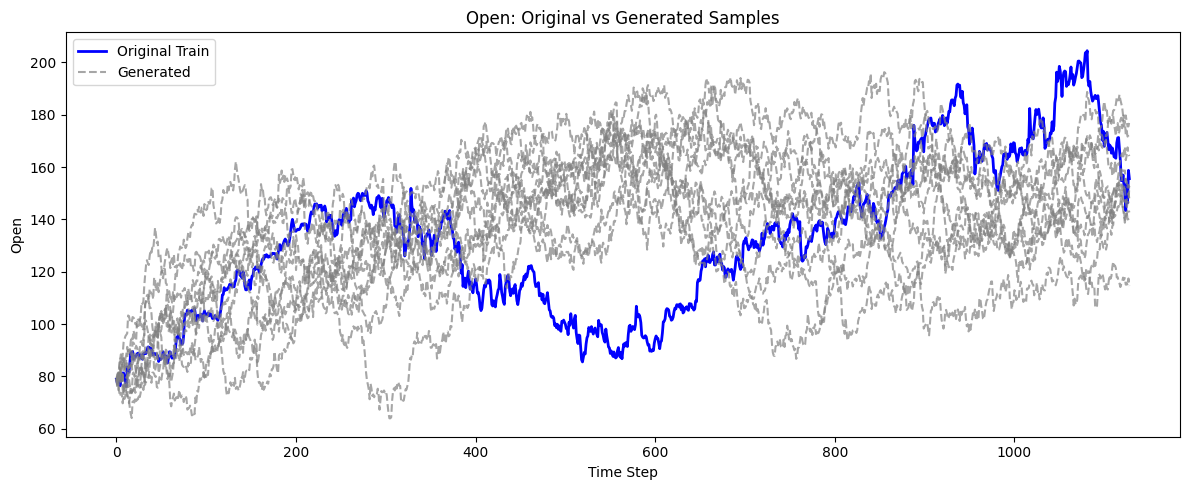

Close (channel 2): min=59.3929, max=205.0951, mean=136.8862


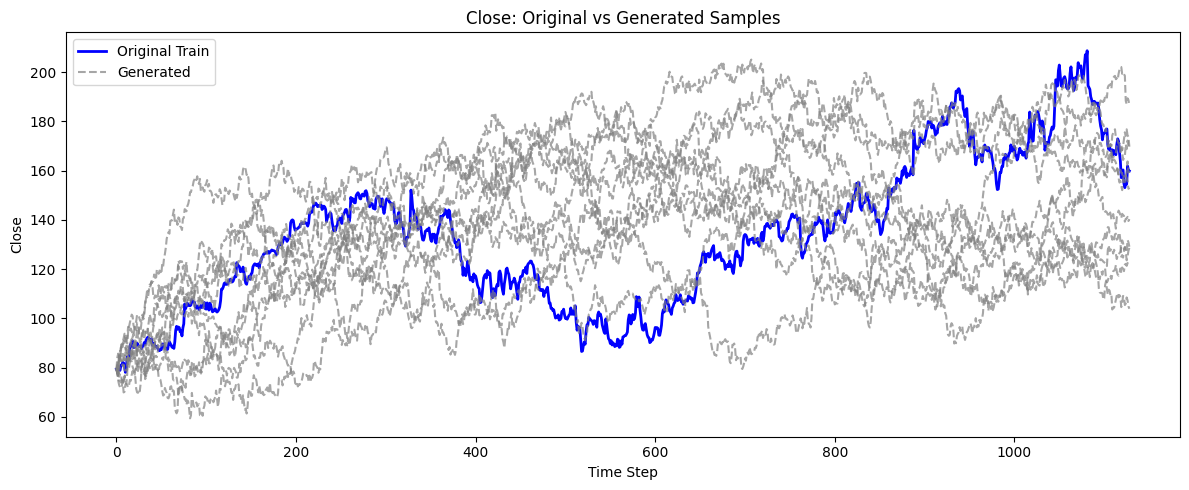

High (channel 3): min=67.4680, max=209.8234, mean=134.1528


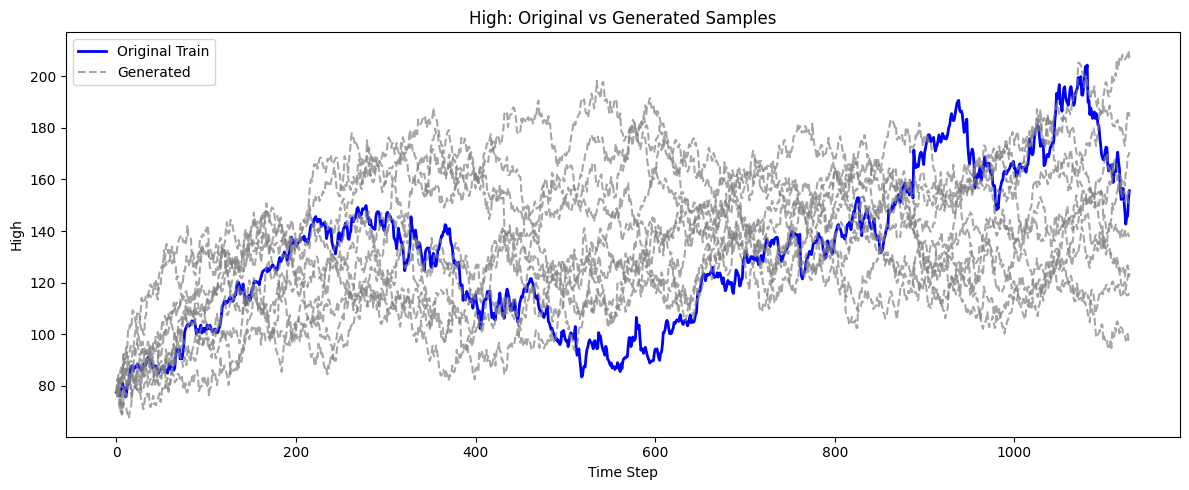

Low (channel 4): min=59.3021, max=222.7794, mean=134.1527


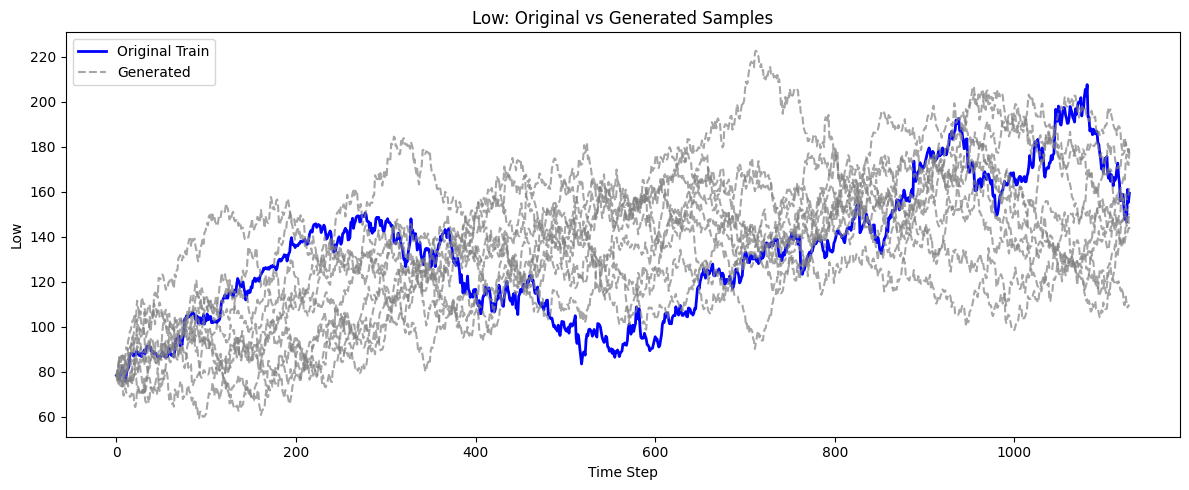

In [6]:
print("\n" + "=" * 50)
print("Validating Ornstein-Uhlenbeck (O-U) Process")
print("=" * 50)

length, num_channels = train_data_para.shape
initial_price = train_data_para[0]

ou_model = OrnsteinUhlenbeckProcess(length=length, num_channels=num_channels)
print(f"O-U Model instantiated: {ou_model}")

print("Fitting O-U model...")
ou_model.fit(train_data_para)

num_generated_samples = 10
ou_generated_data = ou_model.generate(num_generated_samples)
print(f"Generated O-U data shape: {ou_generated_data.shape}")

assert ou_generated_data.shape == (num_generated_samples, length, num_channels), \
    f"O-U: Generated data shape mismatch. Expected ({num_generated_samples}, {length}, {num_channels}), got {ou_generated_data.shape}"
print("O-U: Generated data shape is correct.")

plot_outputs(train_data_para, ou_generated_data, num_generated_samples, length)

### Merton Jump Diffusion


Validating Merton Jump Diffusion (MJD)
MJD Model instantiated: <src.models.parametric.merton_jump_diffusion.MertonJumpDiffusion object at 0x000001F9FD3DF230>
Fitting MJD model...
Generated MJD data shape: torch.Size([10, 1129, 5])
MJD: Generated data shape is correct.
Open (channel 1): min=29.3876, max=340.4741, mean=109.1765


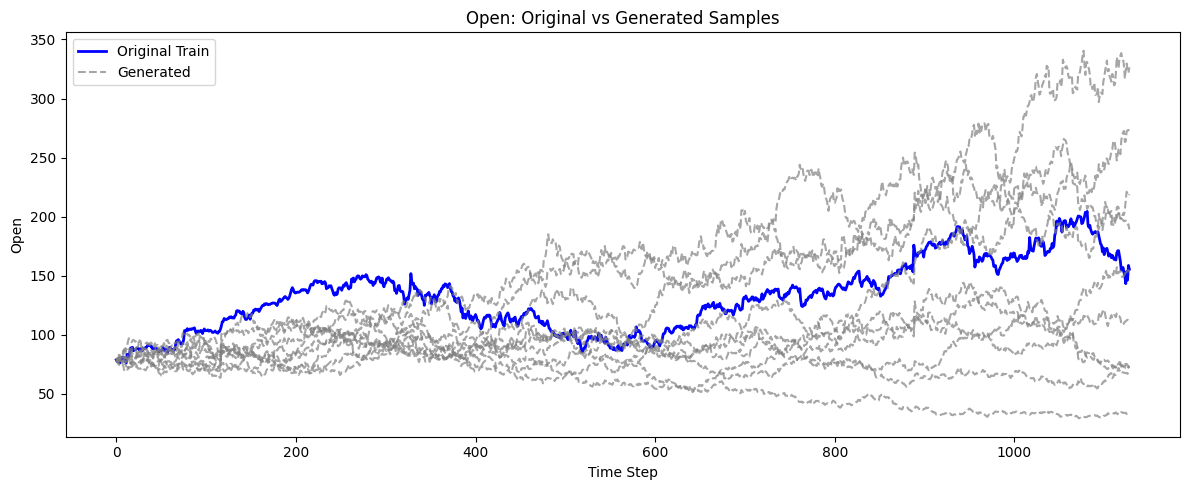

Close (channel 2): min=42.6212, max=625.7541, mean=135.7505


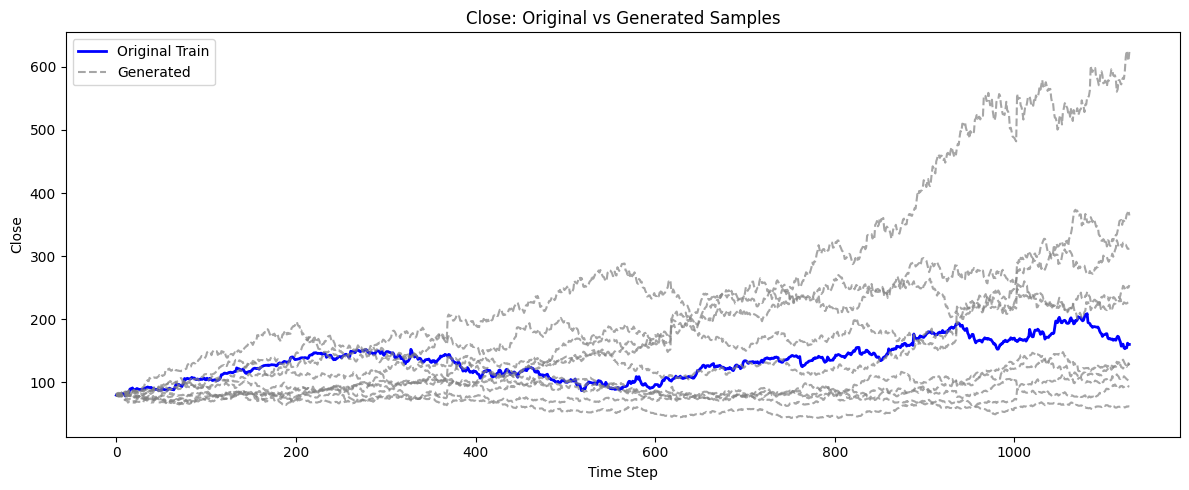

High (channel 3): min=51.4432, max=511.0517, mean=149.2817


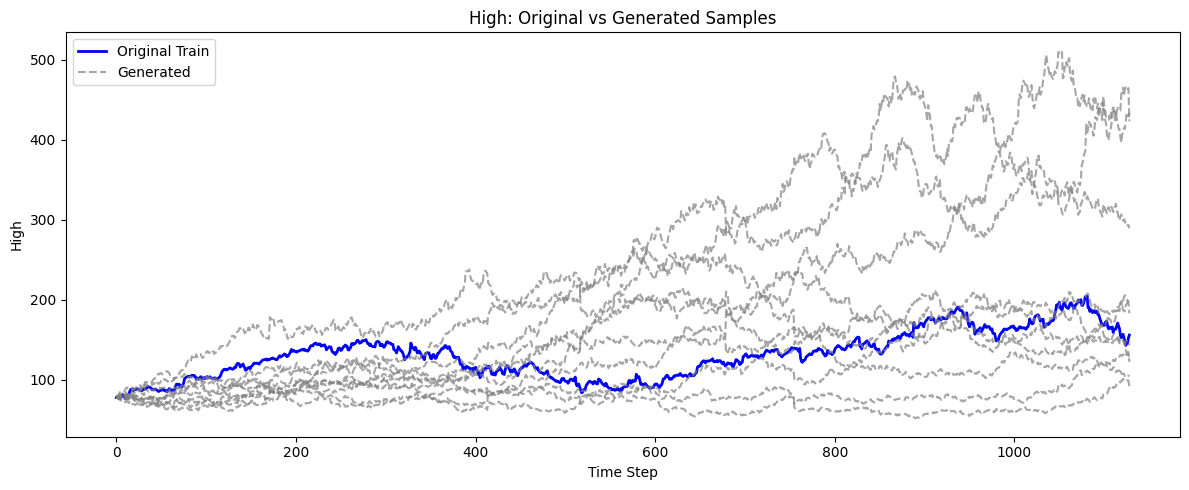

Low (channel 4): min=33.3582, max=438.0643, mean=125.7876


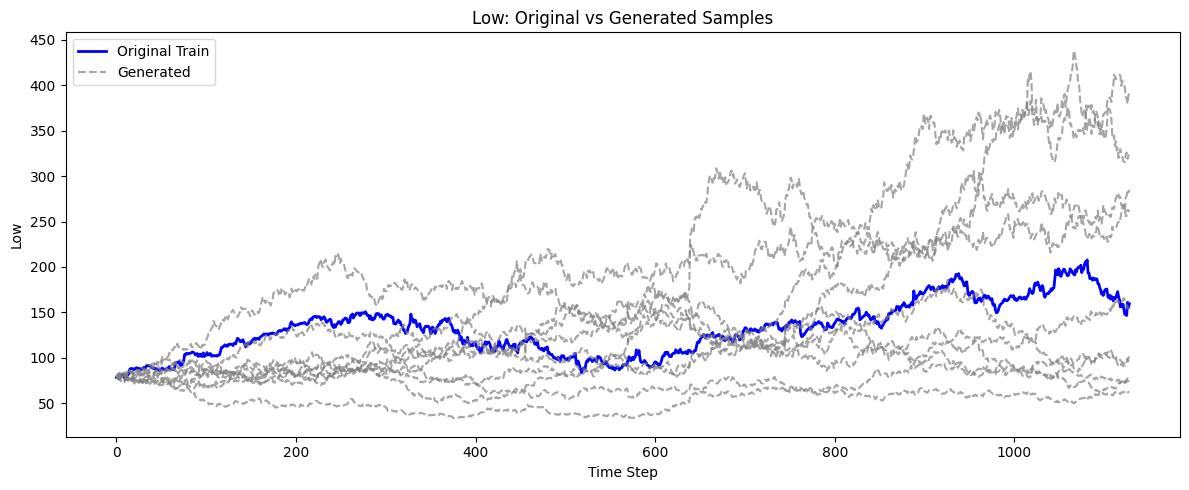

In [7]:
print("\n" + "=" * 50)
print("Validating Merton Jump Diffusion (MJD)")
print("=" * 50)

length, num_channels = train_data_para.shape
initial_price = train_data_para[0]

mjd_model = MertonJumpDiffusion(length=length, num_channels=num_channels)
print(f"MJD Model instantiated: {mjd_model}")

print("Fitting MJD model...")
mjd_model.fit(train_data_para)

num_generated_samples = 10
mjd_generated_data = mjd_model.generate(num_generated_samples)
print(f"Generated MJD data shape: {mjd_generated_data.shape}")

assert mjd_generated_data.shape == (num_generated_samples, length, num_channels), \
    f"MJD: Generated data shape mismatch. Expected ({num_generated_samples}, {length}, {num_channels}), got {mjd_generated_data.shape}"
print("MJD: Generated data shape is correct.")

plot_outputs(train_data_para, mjd_generated_data, num_generated_samples, length)

### GARCH(1, 1)


Validating GARCH(1,1)
GARCH(1,1) Model instantiated: <src.models.parametric.garch11.GARCH11 object at 0x000001F9FD3DC770>
Fitting GARCH(1,1) model...
Generated GARCH(1,1) data shape: torch.Size([10, 1129, 5])
GARCH(1,1): Generated data shape is correct.
Open (channel 1): min=46.9504, max=773.2468, mean=146.0374


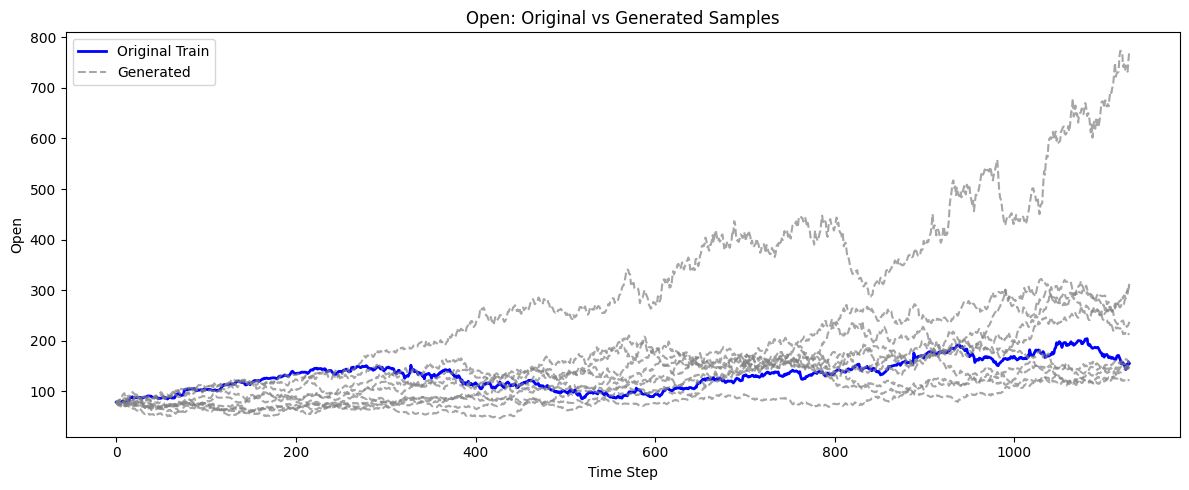

Close (channel 2): min=45.7156, max=1171.9822, mean=166.8910


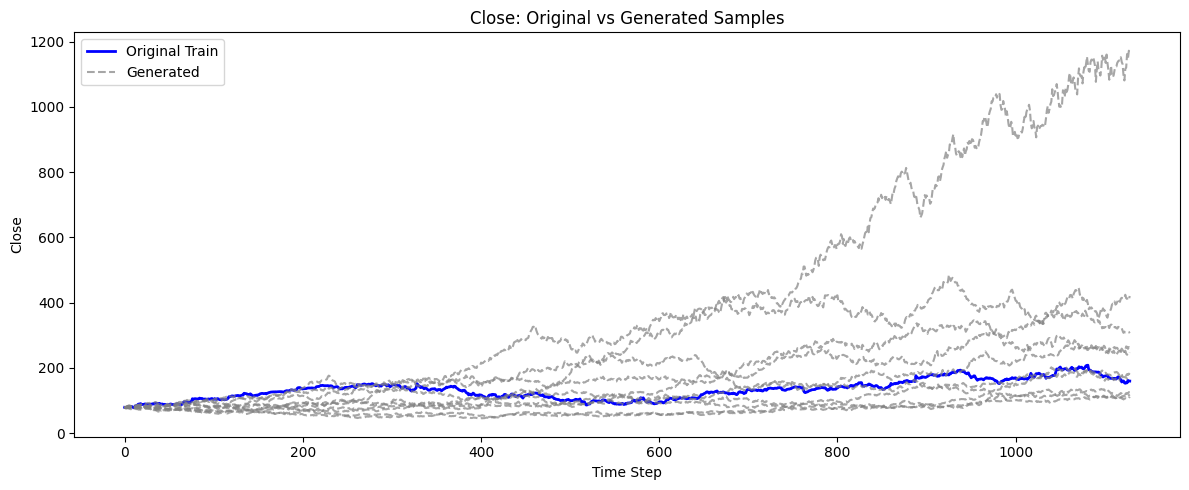

High (channel 3): min=44.6115, max=493.9614, mean=137.3476


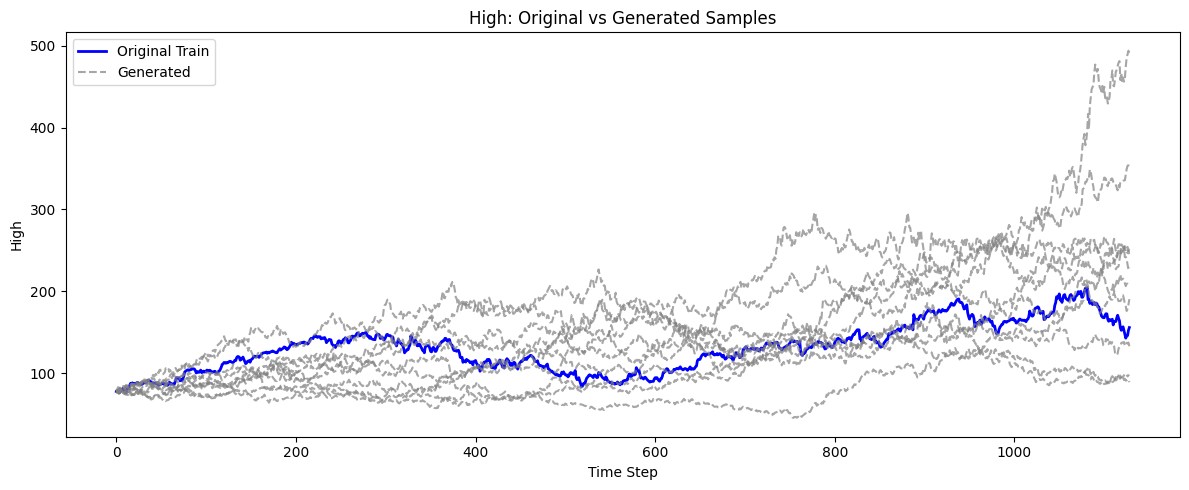

Low (channel 4): min=40.5409, max=525.3775, mean=121.9944


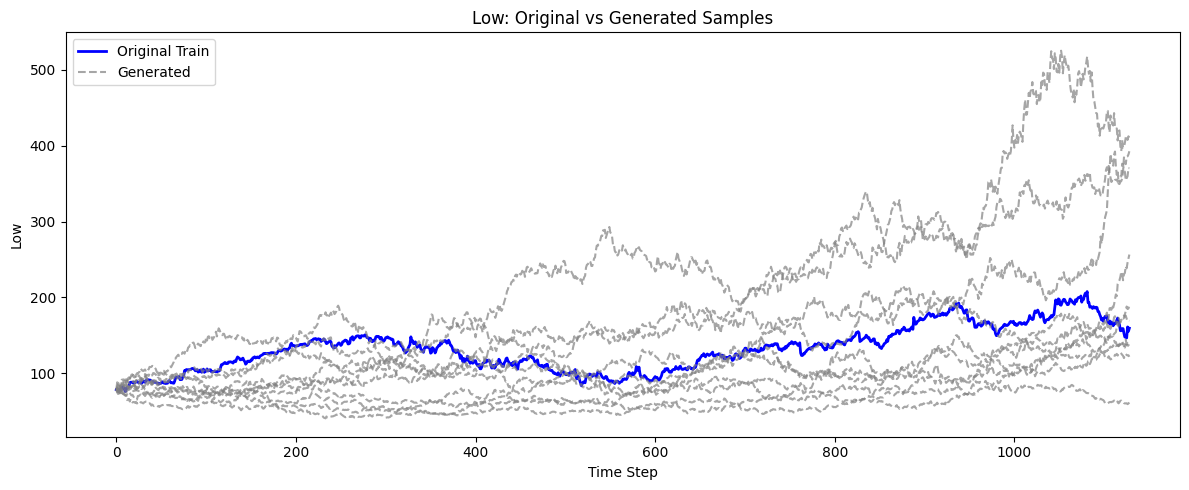

In [8]:
print("\n" + "=" * 50)
print("Validating GARCH(1,1)")
print("=" * 50)

length, num_channels = train_data_para.shape
initial_price = train_data_para[0]

garch_model = GARCH11(length=length, num_channels=num_channels)
print(f"GARCH(1,1) Model instantiated: {garch_model}")

print("Fitting GARCH(1,1) model...")
garch_model.fit(train_data_para)

num_generated_samples = 10
garch_generated_data = garch_model.generate(num_generated_samples)
print(f"Generated GARCH(1,1) data shape: {garch_generated_data.shape}")

assert garch_generated_data.shape == (num_generated_samples, length, num_channels), \
    f"GARCH(1,1): Generated data shape mismatch. Expected ({num_generated_samples}, {length}, {num_channels}), got {garch_generated_data.shape}"
print("GARCH(1,1): Generated data shape is correct.")

plot_outputs(train_data_para, garch_generated_data, num_generated_samples, length)

### Double Exponential Jump Diffusion


Validating Double Exponential Jump Diffusion (DEJD)
DEJD Model instantiated: <src.models.parametric.de_jump_diffusion.DoubleExponentialJumpDiffusion object at 0x000001F9FD84A1B0>
Fitting DEJD model...
Generated DEJD data shape: torch.Size([10, 1129, 5])
DEJD: Generated data shape is correct.
Open (channel 1): min=28.8753, max=548.8289, mean=94.0022


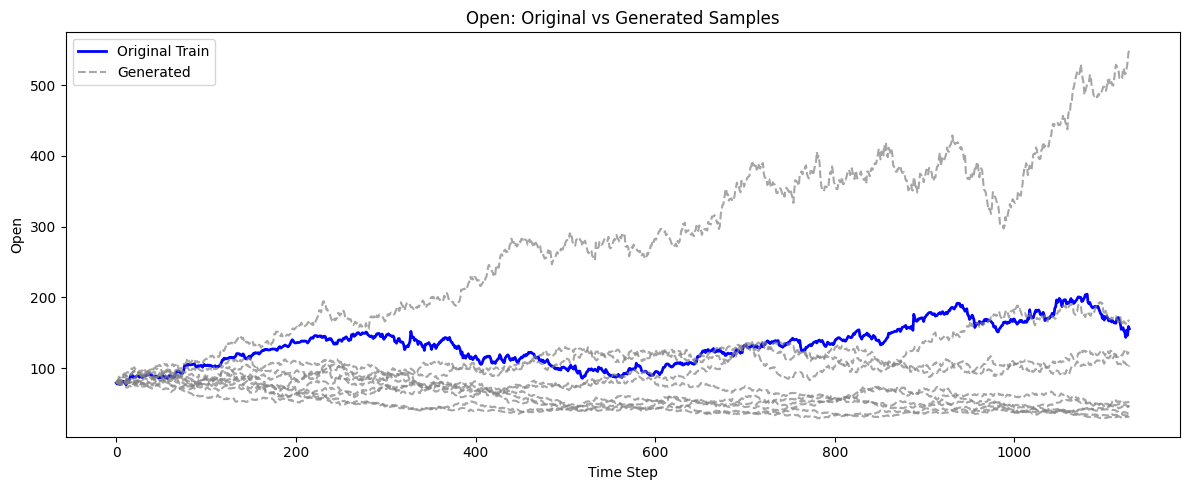

Close (channel 2): min=36.1564, max=412.0741, mean=101.8192


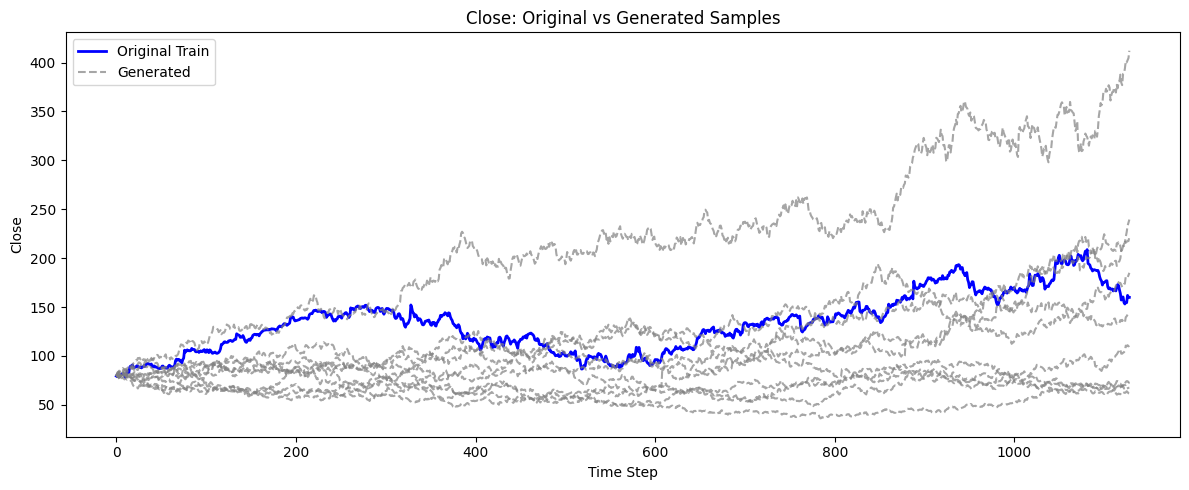

High (channel 3): min=44.1961, max=553.0349, mean=142.0687


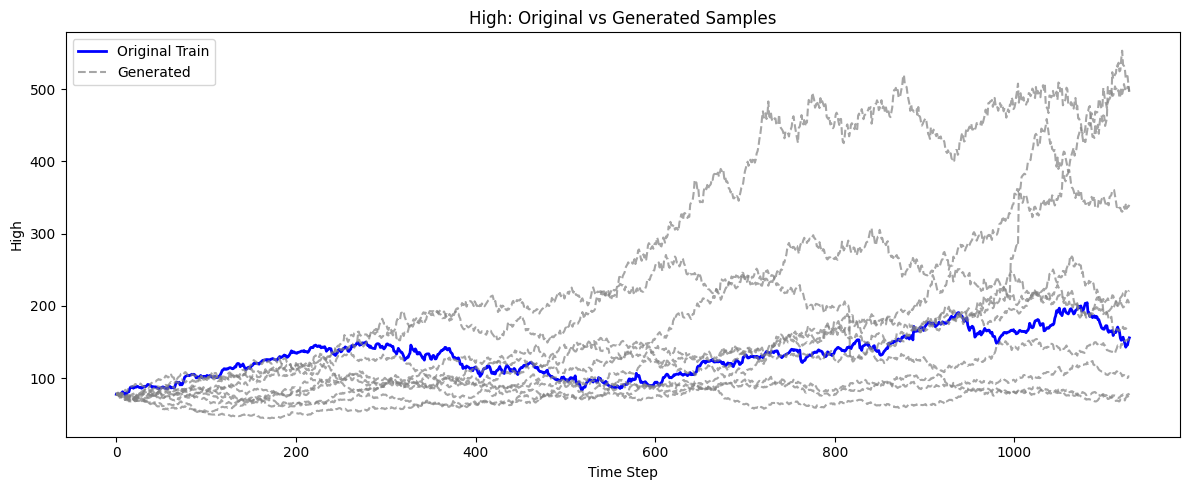

Low (channel 4): min=33.2546, max=488.3596, mean=105.6803


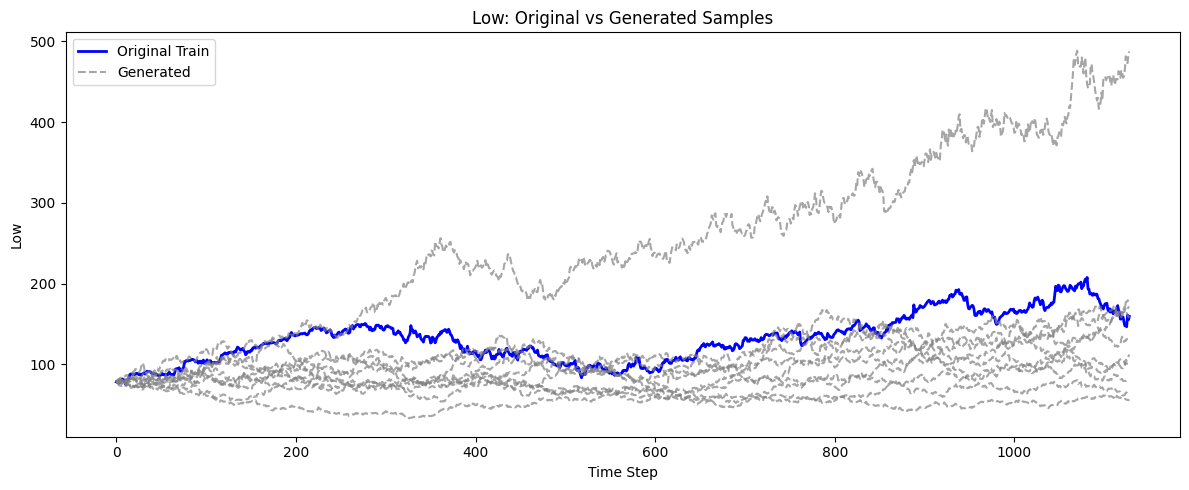

In [9]:
print("\n" + "=" * 50)
print("Validating Double Exponential Jump Diffusion (DEJD)")
print("=" * 50)

length, num_channels = train_data_para.shape
initial_price = train_data_para[0]

dejd_model = DoubleExponentialJumpDiffusion(length=length, num_channels=num_channels)
print(f"DEJD Model instantiated: {dejd_model}")

print("Fitting DEJD model...")
dejd_model.fit(train_data_para)

num_generated_samples = 10
dejd_generated_data = dejd_model.generate(num_generated_samples)
print(f"Generated DEJD data shape: {dejd_generated_data.shape}")

assert dejd_generated_data.shape == (num_generated_samples, length, num_channels), \
    f"DEJD: Generated data shape mismatch. Expected ({num_generated_samples}, {length}, {num_channels}), got {dejd_generated_data.shape}"
print("DEJD: Generated data shape is correct.")

plot_outputs(train_data_para, dejd_generated_data, num_generated_samples, length)

## Deep Learning Model Validation

This section validates the functionality of each deep learning time series generative model. For each model, we will:
1.  Instantiate the model with appropriate parameters.
2.  Train the model using the preprocessed training data.
3.  Generate new synthetic time series samples.
4.  Verify the shape and basic statistics of the generated data.

Note: GAN training can be unstable and convergence is not guaranteed with simple validation. This is primarily to check code execution and output format.



In [10]:
def plot_gan_simulations_mean_dt(
    gan, 
    train_data, 
    num_simulations=10, 
    sequence_length=100, 
    feature_idx=None  # None means plot all channels
):
    """
    Generate and plot multiple GAN simulations on uniform time steps,
    where the step is the mean of all original Δt.

    Args:
        gan: Trained GAN model with .generate(...) method
        train_data: np.ndarray of shape (R, L, N)
        num_simulations: Number of independent sequences to generate
        sequence_length: Length of each generated sequence
        feature_idx: Index of the feature channel to plot (0-based, after timestamp). 
                     If None, plots all channels.
    """
    # Ensure GAN is in evaluation mode
    for net in ['generator', 'supervisor', 'recovery']:
        if hasattr(gan, net):
            getattr(gan, net).eval()

    # Compute mean Δt from original data
    timestamps_all = train_data[:, :, 0]  # shape (R, L)
    delta_ts = np.diff(timestamps_all, axis=1)  # shape (R, L-1)
    mean_dt = np.mean(delta_ts)

    plt.figure(figsize=(12, 6))

    for i in range(num_simulations):
        with torch.no_grad():
            fake_series = gan.generate(
                num_samples=1,
                output_length=sequence_length,
                linear_timestamps=True
            )

        # Convert to numpy if necessary
        if isinstance(fake_series, torch.Tensor):
            fake_series = fake_series.cpu().numpy()

        fake_series = fake_series[0]  # Remove batch dimension
        timestamps = fake_series[:, 0] * mean_dt * sequence_length
        values = fake_series[:, 1:]  # shape (sequence_length, N-1)

        # Plot all channels if feature_idx is None
        if feature_idx is None:
            for ch in range(values.shape[1]):
                plt.plot(timestamps, values[:, ch], label=f'Sim {i+1} Ch {ch}', alpha=0.7)
        else:
            if feature_idx >= values.shape[1]:
                raise ValueError(f"feature_idx={feature_idx} out of bounds for {values.shape[1]} channels")
            plt.plot(timestamps, values[:, feature_idx], label=f'Sim {i+1}', alpha=0.7)

    plt.title(f'{num_simulations} GAN Simulations (Linear Time Steps, mean Δt)')
    plt.xlabel("Time")
    plt.ylabel(f"Feature Value (Normalized)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### TimeGAN



In [ ]:
seq_length = train_data_norm_np.shape[1]
num_channels = train_data_norm_np.shape[2]

# ============================================================
# Initialize and Train TimeGAN
# ============================================================
print("\n" + "=" * 50)
print("Training TimeGAN with Unevenly Spaced Time Steps")
print("=" * 50)

# Initialize TimeGAN with updated API
time_gan = TimeGAN(
    seq_length=seq_length,  # Length of each time series sequence 
    num_channels=num_channels,  # Number of channels (including timestamps)
    latent_dim=64,
    hidden_dim=128,
    lr=2e-4
)
print(f"TimeGAN model initialized on device: {time_gan.device}")

# Train the model on normalized data
print("Training TimeGAN model...")
time_gan.fit(train_loader_norm, epochs=1)
print("TimeGAN training complete.")



Training TimeGAN with Unevenly Spaced Time Steps
TimeGAN model initialized on device: cpu
Training TimeGAN model...


Epoch 1/1:  25%|██▌       | 8/32 [00:12<00:38,  1.59s/it]

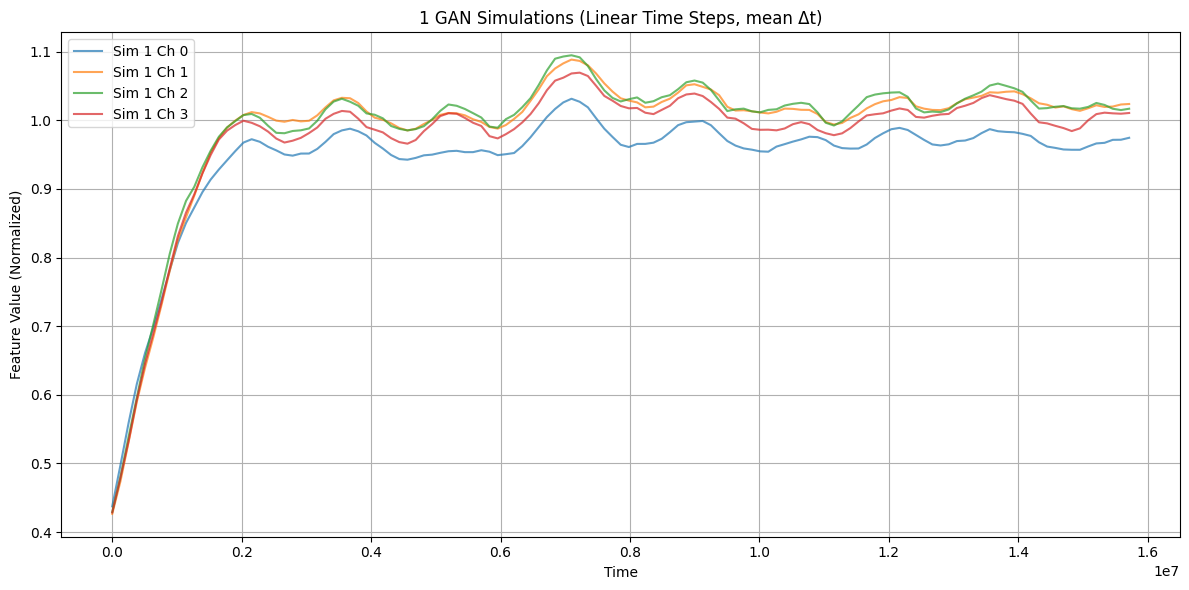

In [ ]:
plot_gan_simulations_mean_dt(gan=time_gan, train_data=train_data_norm_np, num_simulations=1, sequence_length=125)